# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## Enter The Frontier!

And now - we put Frontier Models to the test.

### 2 important points:

It's important to appreciate that we aren't Training the frontier models. We're only providing them with the Test dataset to see how they perform. They don't gain the benefit of the 400,000 training examples that we provided to the Traditional ML models.

HAVING SAID THAT...

It's entirely possible that in their monstrously large training data, they've already been exposed to all the products in the training AND the test set. So there could be test "contamination" here which gives them an unfair advantage. We should keep that in mind.

In [52]:
# imports

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
#from items import Item
from jupyter_notebook_ai_clone.llm_udemy.llm_engineering.week6.items import Item 
#from loaders import ItemLoader
from jupyter_notebook_ai_clone.llm_udemy.llm_engineering.week6.loaders import ItemLoader
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI
from anthropic import Anthropic

In [53]:
# moved our Tester into a separate package
# call it with Tester.test(function_name, test_dataset)

# from testing import Tester
from jupyter_notebook_ai_clone.llm_udemy.llm_engineering.week6.testing import Tester

In [54]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [55]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [56]:
openai = OpenAI()
claude = Anthropic()

In [57]:
%matplotlib inline

In [58]:
# Let's avoid curating all our data again! Load in the pickle files:

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

# Before we look at the Frontier

## There is one more model we could consider

In [59]:
# Write the test set to a CSV

import csv
with open('human_input.csv', 'w', encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    for t in test[:250]:
        writer.writerow([t.test_prompt(), 0])

In [62]:
# Read it back in
# from jupyter_notebook_ai_clone.llm_udemy.llm_engineering.week6
path ="jupyter_notebook_ai_clone/llm_udemy/llm_engineering/week6"
human_predictions = []
with open(f"{path}/human_output.csv", 'r', encoding="utf-8") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        human_predictions.append(float(row[1]))

In [63]:
def human_pricer(item):
    idx = test.index(item)
    return human_predictions[idx]

1: Guess: $120.00 Truth: $13.99 Error: $106.01 SLE: 4.36 Item: Kastar NP-FH50 Battery (1-Pack) and Char...
2: Guess: $80.00 Truth: $699.00 Error: $619.00 SLE: 4.65 Item: Sony a5100 16-50mm Mirrorless Digital Ca...
3: Guess: $35.00 Truth: $69.99 Error: $34.99 SLE: 0.46 Item: 1Mii 2.4Ghz Wireless Audio Transmitter R...
4: Guess: $350.00 Truth: $64.95 Error: $285.05 SLE: 2.80 Item: Fotodiox Pro Lens Mount Adapter - Bronic...
5: Guess: $75.00 Truth: $110.90 Error: $35.90 SLE: 0.15 Item: FOSA 10" Car Digital TV, ATSC Portable H...
6: Guess: $12.00 Truth: $5.99 Error: $6.01 SLE: 0.38 Item: Pineapple Vinyl Decal - Laptop, Decor, W...
7: Guess: $115.00 Truth: $529.00 Error: $414.00 SLE: 2.31 Item: Canon EOS 50D 15.1MP Digital SLR Camera ...
8: Guess: $100.00 Truth: $14.98 Error: $85.02 SLE: 3.40 Item: UpBright New Global 5V AC/DC Adapter Com...
9: Guess: $300.00 Truth: $113.99 Error: $186.01 SLE: 0.93 Item: OEM Electrolux Dryer Lint Filter Screen ...
10: Guess: $80.00 Truth: $829.99 Error: $74

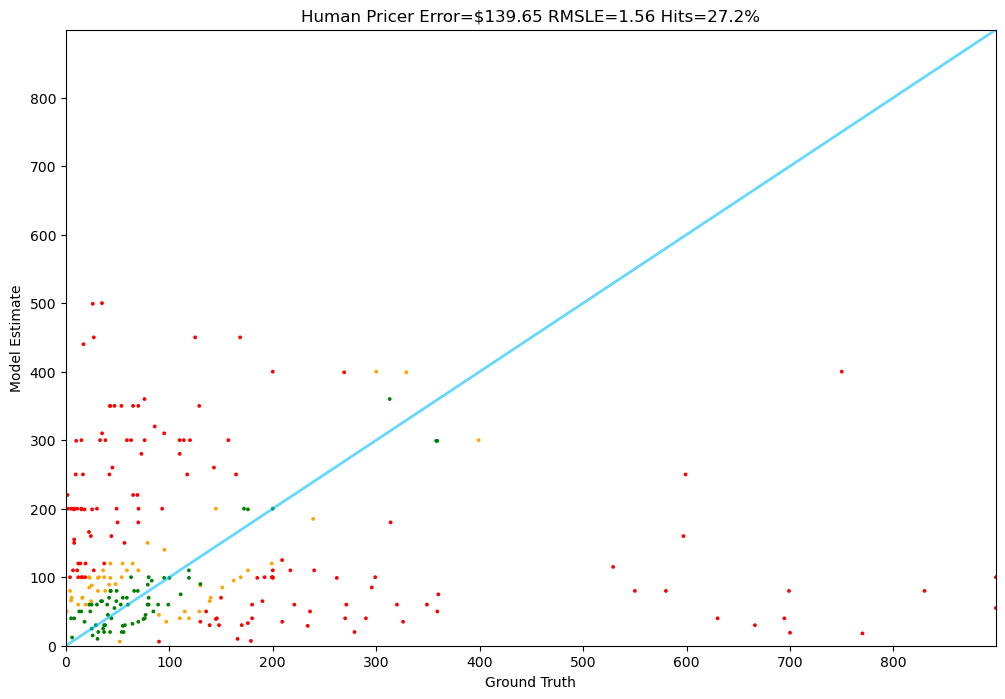

In [64]:
Tester.test(human_pricer, test)

## First, the humble but mighty GPT-4o-mini

It's called mini, but it packs a punch.

In [65]:
# First let's work on a good prompt for a Frontier model
# Notice that I'm removing the " to the nearest dollar"
# When we train our own models, we'll need to make the problem as easy as possible, 
# but a Frontier model needs no such simplification.

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [66]:
# Try this out

messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': 'How much does this cost?\n\nKastar Battery and Charger Replacement for Sony\nBullet Point 1 Kastar Mini Rapid A/C Charger Features a Fold-out US Plug, Worldwide Input Voltage, Car Charging Adapter, and European Plug. Bullet Point 2 Kastar Battery Utra-high Capacity. Use high quality Japanese Cells for longer battery life with no Memory Effect. Bullet Point 3 Charge indication Green lights for standby, Red is for charging and with automatic constant current control prevents battery from overcharging, short circuit, and electronic shock. Bullet Point 4 All Items 100% decoded and 100% Compatible with the Original Camera, Battery, and Power Accessories. Bullet Point 5 All Items Include 30-day Money Back and 3-YEAR Manufacturer Warranty. Description Details Package Includes 1 x Battery 1 x Travel'},
 {'role': 'assistant', 'content': 'Price is $'}]

In [67]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [68]:
get_price("The price is roughly $99.99 because blah blah")

99.99

In [69]:
# The function for gpt-4o-mini

def gpt_4o_mini(item):
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [70]:
test[0].price

13.99

1: Guess: $29.00 Truth: $13.99 Error: $15.01 SLE: 0.48 Item: Kastar NP-FH50 Battery (1-Pack) and Char...
2: Guess: $350.00 Truth: $699.00 Error: $349.00 SLE: 0.48 Item: Sony a5100 16-50mm Mirrorless Digital Ca...
3: Guess: $49.99 Truth: $69.99 Error: $20.00 SLE: 0.11 Item: 1Mii 2.4Ghz Wireless Audio Transmitter R...
4: Guess: $99.95 Truth: $64.95 Error: $35.00 SLE: 0.18 Item: Fotodiox Pro Lens Mount Adapter - Bronic...
5: Guess: $89.99 Truth: $110.90 Error: $20.91 SLE: 0.04 Item: FOSA 10" Car Digital TV, ATSC Portable H...
6: Guess: $5.99 Truth: $5.99 Error: $0.00 SLE: 0.00 Item: Pineapple Vinyl Decal - Laptop, Decor, W...
7: Guess: $490.00 Truth: $529.00 Error: $39.00 SLE: 0.01 Item: Canon EOS 50D 15.1MP Digital SLR Camera ...
8: Guess: $15.99 Truth: $14.98 Error: $1.01 SLE: 0.00 Item: UpBright New Global 5V AC/DC Adapter Com...
9: Guess: $24.99 Truth: $113.99 Error: $89.00 SLE: 2.21 Item: OEM Electrolux Dryer Lint Filter Screen ...
10: Guess: $699.99 Truth: $829.99 Error: $130.00 SLE

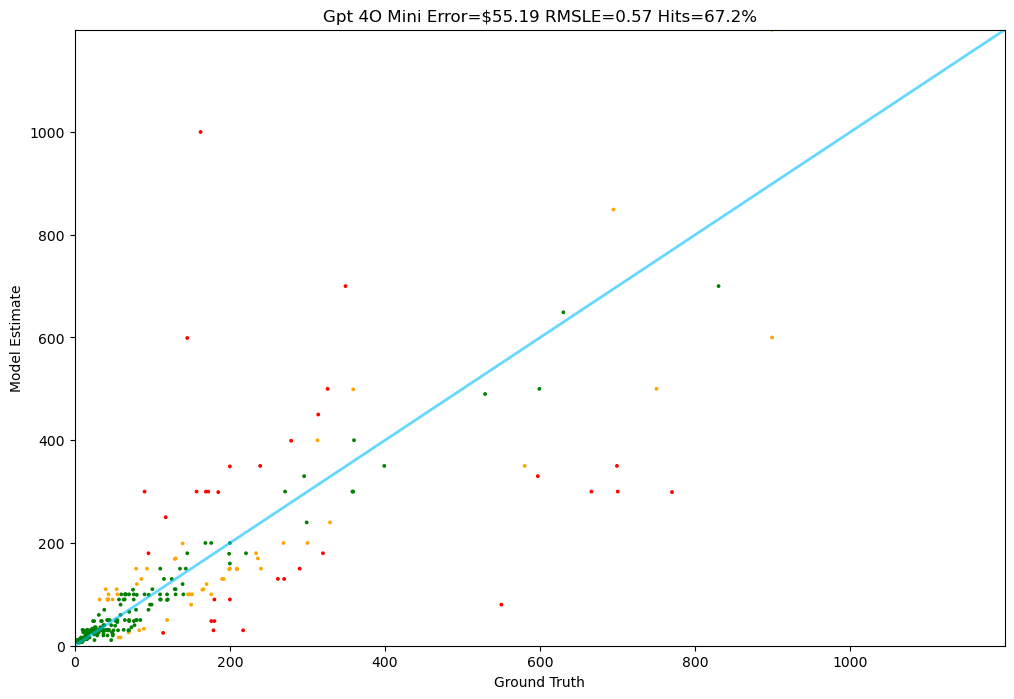

In [71]:
Tester.test(gpt_4o_mini, test)

In [72]:
def gpt_4o_frontier(item):
    response = openai.chat.completions.create(
        model="gpt-4o-2024-08-06", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

1: Guess: $24.99 Truth: $13.99 Error: $11.00 SLE: 0.30 Item: Kastar NP-FH50 Battery (1-Pack) and Char...
2: Guess: $499.99 Truth: $699.00 Error: $199.01 SLE: 0.11 Item: Sony a5100 16-50mm Mirrorless Digital Ca...
3: Guess: $59.99 Truth: $69.99 Error: $10.00 SLE: 0.02 Item: 1Mii 2.4Ghz Wireless Audio Transmitter R...
4: Guess: $49.95 Truth: $64.95 Error: $15.00 SLE: 0.07 Item: Fotodiox Pro Lens Mount Adapter - Bronic...
5: Guess: $99.99 Truth: $110.90 Error: $10.91 SLE: 0.01 Item: FOSA 10" Car Digital TV, ATSC Portable H...
6: Guess: $8.99 Truth: $5.99 Error: $3.00 SLE: 0.13 Item: Pineapple Vinyl Decal - Laptop, Decor, W...
7: Guess: $250.00 Truth: $529.00 Error: $279.00 SLE: 0.56 Item: Canon EOS 50D 15.1MP Digital SLR Camera ...
8: Guess: $12.99 Truth: $14.98 Error: $1.99 SLE: 0.02 Item: UpBright New Global 5V AC/DC Adapter Com...
9: Guess: $24.99 Truth: $113.99 Error: $89.00 SLE: 2.21 Item: OEM Electrolux Dryer Lint Filter Screen ...
10: Guess: $850.00 Truth: $829.99 Error: $20.01 SLE

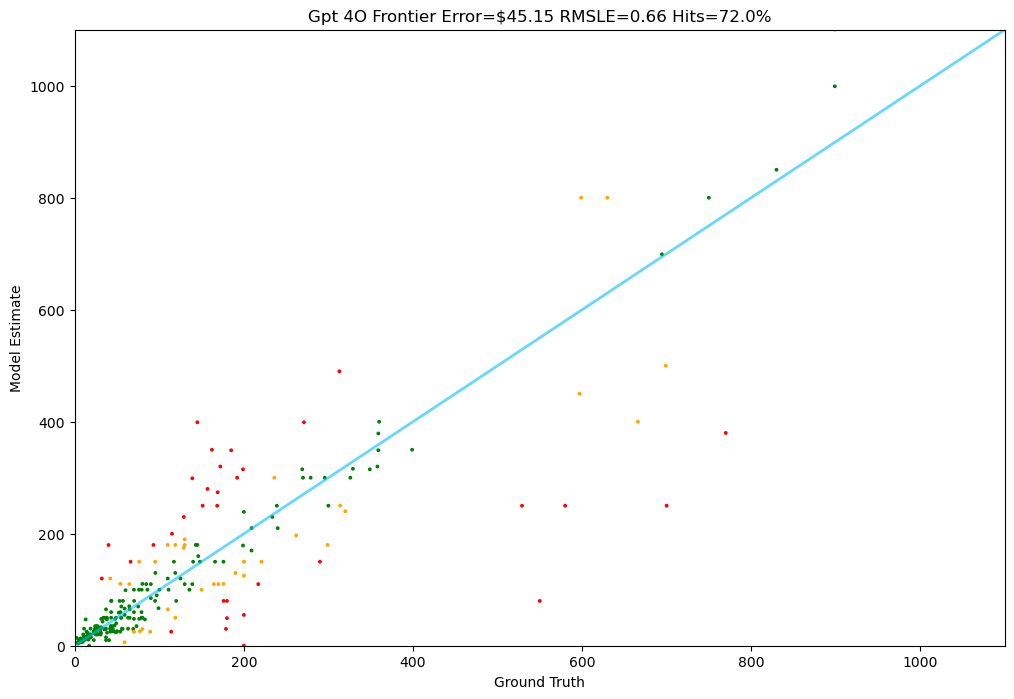

In [73]:
# The function for gpt-4o - the August model
# Note that it cost me about 1-2 cents to run this (pricing may vary by region)
# You can skip this and look at my results instead

Tester.test(gpt_4o_frontier, test)

In [75]:
def claude_3_point_5_sonnet(item):
    messages = messages_for(item)
    system_message = messages[0]['content']
    messages = messages[1:]
    response = claude.messages.create(
        model="claude-3-5-sonnet-20240620",
        max_tokens=5,
        system=system_message,
        messages=messages
    )
    reply = response.content[0].text
    return get_price(reply)

In [76]:
# The function for Claude 3.5 Sonnet
# It also cost me about 1-2 cents to run this (pricing may vary by region)
# You can skip this and look at my results instead

Tester.test(claude_3_point_5_sonnet, test)

1: Guess: $21.99 Truth: $13.99 Error: $8.00 SLE: 0.18 Item: Kastar NP-FH50 Battery (1-Pack) and Char...
2: Guess: $349.99 Truth: $699.00 Error: $349.01 SLE: 0.48 Item: Sony a5100 16-50mm Mirrorless Digital Ca...
3: Guess: $49.99 Truth: $69.99 Error: $20.00 SLE: 0.11 Item: 1Mii 2.4Ghz Wireless Audio Transmitter R...
4: Guess: $89.95 Truth: $64.95 Error: $25.00 SLE: 0.10 Item: Fotodiox Pro Lens Mount Adapter - Bronic...
5: Guess: $99.99 Truth: $110.90 Error: $10.91 SLE: 0.01 Item: FOSA 10" Car Digital TV, ATSC Portable H...
6: Guess: $5.99 Truth: $5.99 Error: $0.00 SLE: 0.00 Item: Pineapple Vinyl Decal - Laptop, Decor, W...
7: Guess: $1,399.99 Truth: $529.00 Error: $870.99 SLE: 0.94 Item: Canon EOS 50D 15.1MP Digital SLR Camera ...
8: Guess: $13.99 Truth: $14.98 Error: $0.99 SLE: 0.00 Item: UpBright New Global 5V AC/DC Adapter Com...
9: Guess: $18.99 Truth: $113.99 Error: $95.00 SLE: 3.06 Item: OEM Electrolux Dryer Lint Filter Screen ...
10: Guess: $649.99 Truth: $829.99 Error: $180.00 S

KeyboardInterrupt: 